# Machine Learning Engineer Nanodegree Capstone Project
## Santa's Mssion
Santa is planning to deliver presents to children in Taiwan in Christmas night. He asks the shortest path and wishes to train his reindeer friends to go by themselves then he can have tea time leisurely in the future. 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
data = pd.read_csv('gifts.csv')

# Success
print("Gift list dataset has {} destination nodes.".format(data.shape[0]))

Gift list dataset has 100000 destination nodes.


### Reduce the scope of the map 
Considering my project focuses on a small map, I filter out the locations in Taiwan as my list.  

In [2]:
import reverse_geocode

data_Taiwan = []    

for i in range(data.shape[0]):
    loc = reverse_geocode.search([(data.iloc[i]['Latitude'],data.iloc[i]['Longitude'])])
    if loc[0]['country'] == "Taiwan":
        data_Taiwan.append((data.iloc[i]['Latitude'],data.iloc[i]['Longitude']))

print("Length of Taiwan gift list :{}".format(len(data_Taiwan)))

Length of Taiwan gift list :26


To Visualize the list of gifts list.

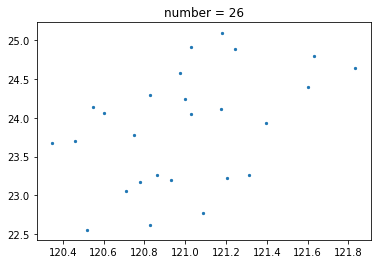

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

y, x = zip(*data_Taiwan)
plt.scatter(x, y, s=5)
plt.title("number = {}".format(len(data_Taiwan)))
plt.show()

### Initialization
States: a state S is a sequence of actions on a graph G.  
Actions: an action A is a node of G that is not part of the current state S.  
Rewards: minus of distance is the reward. 

In [4]:
# always start from location 0
start = 0

# the number of locations(gifts)
num = len(data_Taiwan)

Calculate the distance between two latitude-longitude points.

In [5]:
from haversine import haversine

def calculate_distance(src, dst):
    return((int)(haversine((data_Taiwan[src][0], data_Taiwan[src][1]),(data_Taiwan[dst][0], data_Taiwan[dst][1]))))    

Build a distance mapping table to look up quickly. 

In [6]:
table = [[0 for x in range(num)] for y in range(num)] 

for i in range(num):
    for j in range(num):
        table[i][j] = calculate_distance(i, j)

def distance_table(src, dst):
    return table[src][dst]

Plot the visited route.

In [7]:
def plot_route(visit):
    lx = []
    ly = []

    for v in visit:
        lx.append(data_Taiwan[v][1])
        ly.append(data_Taiwan[v][0])

    plt.plot(lx, ly)
    plt.scatter(x, y, s=5)
    plt.title("visited map")
    plt.show()

### Greedy algorithm
Greedy algorithm is as the benchmark model.

total distance: 997
visited sequence: [0, 10, 13, 7, 21, 17, 8, 18, 22, 3, 23, 16, 5, 19, 4, 11, 25, 9, 12, 1, 6, 15, 24, 2, 14, 20] 


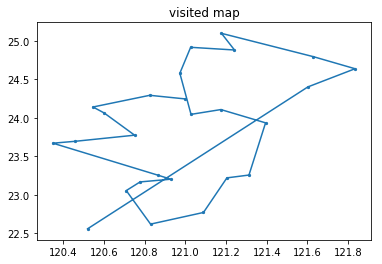

In [8]:
# init
loc = []
visit = []

for i in range(num):
    loc.append(i)
    
last = start
total = 0

while True:
    # move the selected location to visiting list
    loc.remove(last)
    visit.append(last)
    
    # terminate 
    if len(loc) == 0:
        # back to start location
        #visit.append(start)
        #dist = calculate_distance(last, start)
        #total += dist
        break
    
    # init a very long distance
    short = 655360

    # choose the nearest unvisited location as next move
    for n in loc:
        dist = calculate_distance(last, n)
        
        if dist < short:
            candidate = n 
            short = dist
    
    last = candidate
    total += short
    
print("total distance: {}\nvisited sequence: {} ".format(total, visit))
plot_route(visit)

### $\epsilon$-greedy policy 

In [9]:
def epsilon_greedy_probs(Q_state, visit, episode, eps=None):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    # set epsilon
    epsilon = 1.0 / episode
    if eps is not None:
        epsilon = eps

    # init same probabilities for each action
    policy = np.ones(num) * epsilon / (num - len(visit))
    
    # the probabilities of having visited locations are 0
    Q_new = Q_state.copy()
    
    for n in visit:
        Q_new[n] = -65536
        policy[n] = 0
    
    # update the max value of action in Q to higher probabilities
    policy[np.argmax(Q_new)] = 1 - epsilon + (epsilon / (num - len(visit)))
    
    return policy

### Q-learning

In [11]:
from collections import defaultdict, deque
import sys
import random
    
def q_learning(episode_num, alpha, gamma=1.0, dyna_num=None):
    # initialize action-value function
    Q = defaultdict(lambda: np.zeros(num))
    
    # scores
    plot_num = 100
    plot_scores = []    
    scores = deque(maxlen=plot_num)   
    shortest_episode = 0
    shortest_path = 655360
    
    # loop over episodes
    for e in range(1, episode_num+1):
        # monitor progress
        if e % 100 == 0:
            print("\rEpisode {}/{}".format(e, episode_num), end="")
            sys.stdout.flush()
        
        # init
        total = 0
        visit = []
        visit.append(start)
        state = ",".join(map(str, visit))
            
        while True:
            # get epsilon-greedy action probabilities
            policy = epsilon_greedy_probs(Q[state], visit, e)

            # pick action A
            action = np.random.choice(np.arange(num), p=policy)

            # calculate reward
            reward = -distance_table(visit[-1], action)
            
            # total kilometer traveled
            total -= reward
            
            # update Q
            visit.append(action)
            next_state = ",".join(map(str, visit))
            
            Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * np.max(Q[next_state])) - Q[state][action]))
            
            state = next_state
            
            # dyna Q
            if dyna_num is not None:
                for _ in range(dyna_num):
                    # exclude start location
                    loc_num = np.random.randint(1, high=num-1)

                    # random state
                    dyna_state_sample = random.sample(range(num - 1), loc_num)
                    
                    dyna_state = [start]
                    for x in dyna_state_sample:
                        dyna_state.append(x + 1)
                    
                    # next state
                    next_dyna_state = ",".join(map(str, dyna_state))

                    # select the last one of random state sequence as the next action
                    dyna_action = dyna_state.pop()

                    # calculate reward
                    dyna_reward = -distance_table(dyna_state[-1], dyna_action) if len(dyna_state) != 0 else -distance_table(start, dyna_action)

                    dyna_state = ",".join(map(str, dyna_state))
                    
                    # debug
                    #print("dyna_state:{} next_dyna_state:{} dyna_action:{} dyna_reward:{}".format(dyna_state, next_dyna_state, dyna_action, dyna_reward))
                    
                    Q[dyna_state][dyna_action] = Q[dyna_state][dyna_action] + (alpha * (dyna_reward + (gamma * np.max(Q[next_dyna_state])) - Q[dyna_state][dyna_action]))
            
            # done
            if len(visit) >= num :
                if total < shortest_path:
                    shortest_episode = e
                    shortest_path = total
                    shortest = visit.copy()
                break
        
        scores.append(total)
        if (e % plot_num == 0):
            plot_scores.append(np.mean(scores))
        
    # debug
    #print("Q:{} \nlen:{}".format(Q, len(Q)))
    
    # plot performance
    plt.plot(np.linspace(0,episode_num,len(plot_scores)), np.asarray(plot_scores))
    plt.xlabel('Episode number')
    plt.ylabel('The total distance of the tour')
    plt.show()
    
    # print best 100-episode performance
    print(('Best average reward over %d episodes: ' % plot_num), np.min(plot_scores))
    
    # print the shortest route
    print("\nThe shortest distance is {} at {} episode.".format(shortest_path, shortest_episode))
    print("The visited sequence: {}".format(shortest))
    plot_route(shortest)
    
    return Q

Episode 20000/20000

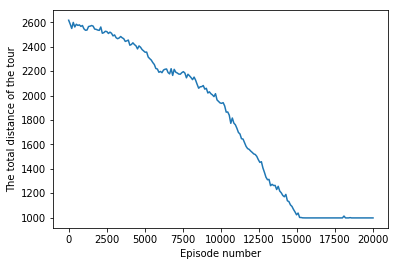

Best average reward over 100 episodes:  997.0

The shortest distance is 984 at 13211 episode.
The visited sequence: [0, 10, 13, 7, 21, 17, 8, 18, 22, 3, 23, 16, 5, 19, 4, 11, 25, 9, 12, 1, 15, 6, 24, 2, 14, 20]


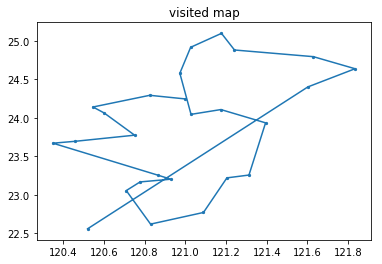

In [12]:
# obtain the estimated optimal policy and corresponding action-value function
sarsamax = q_learning(20000, 0.01)

### Expected Sarsa 

In [13]:
def expected_sarsa(episode_num, alpha, gamma=1.0):
    # initialize action-value function
    Q = defaultdict(lambda: np.zeros(num))
    
    # scores
    plot_num = 100
    plot_scores = []
    scores = deque(maxlen=plot_num)
    shortest_episode = 0
    shortest_path = 655360
    
    # loop over episodes
    for e in range(1, episode_num+1):
        # monitor progress
        if e % 100 == 0:
            print("\rEpisode {}/{}".format(e, episode_num), end="")
            sys.stdout.flush()
        
        # init
        total = 0
        visit.clear()
        visit.append(start)
        state = ",".join(map(str, visit))
            
        while True:
            # get epsilon-greedy action probabilities
            policy = epsilon_greedy_probs(Q[state], visit, e, 0.005)
            
            # pick action A
            action = np.random.choice(np.arange(num), p=policy)

            # calculate reward
            reward = -distance_table(visit[-1], action)

            # total kilometer traveled
            total -= reward
            
            # update Q
            visit.append(action)
            next_state = ",".join(map(str, visit))
            
            Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * np.dot(Q[next_state], policy)) - Q[state][action]))
            
            state = next_state
            
            # done
            if len(visit) >= num :
                if total < shortest_path:
                    shortest_episode = e
                    shortest_path = total
                    shortest = visit.copy()
                break
        
        scores.append(total)
        if (e % plot_num == 0):
            plot_scores.append(np.mean(scores))
            
    # debug
    #print("Q:{}".format(Q))
    
    # plot performance
    plt.plot(np.linspace(0,episode_num,len(plot_scores)), np.asarray(plot_scores))
    plt.xlabel('Episode number')
    plt.ylabel('The total distance of the tour')
    plt.show()
    
    # print best 100-episode performance
    print(('Best average reward over %d episodes: ' % plot_num), np.min(plot_scores))
    
    # print the shortest route
    print("\nThe shortest distance is {} at {} episode.".format(shortest_path, shortest_episode))
    print("The visited sequence: {}".format(shortest))
    plot_route(shortest)
    
    return Q

Episode 20000/20000

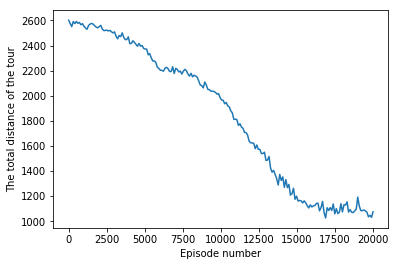

Best average reward over 100 episodes:  1026.09

The shortest distance is 984 at 13645 episode.
The visited sequence: [0, 10, 13, 7, 21, 17, 8, 18, 22, 3, 23, 16, 5, 19, 4, 11, 25, 9, 12, 1, 15, 6, 24, 2, 14, 20]


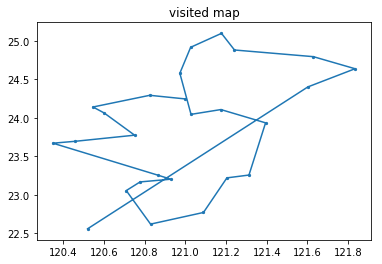

In [14]:
expsarsa = expected_sarsa(20000, 0.01)

### Dyna-Q

Episode 20000/20000

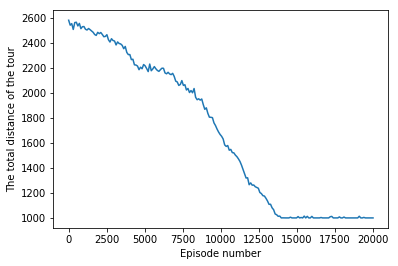

Best average reward over 100 episodes:  997.0

The shortest distance is 984 at 11842 episode.
The visited sequence: [0, 10, 13, 7, 21, 17, 8, 18, 22, 3, 23, 16, 5, 19, 4, 11, 25, 9, 12, 1, 15, 6, 24, 2, 14, 20]


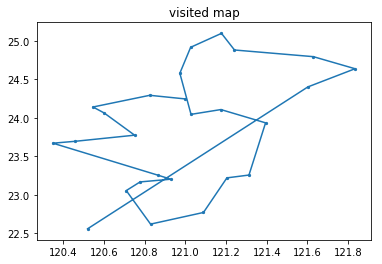

In [15]:
dyna = q_learning(20000, 0.01, 1.0, 10)